# Getting started with PyTorch
In this notebook, you can load a pretrained model and fine-tune it on the desired task.
Datasets available: CIFAR10, CIFAR100 and Imagenet-1k

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# not mandatory
import io
from PIL import Image
from tqdm import tqdm

## Load data

Define transforms and load datasets

In [5]:
data_dir = '/srv/newpenny/dataset'

In [38]:
dataset = 'CIFAR100'
data_path = os.path.join(data_dir, dataset)
if dataset=='imagenet-1k':
    dataset='ImageNet'

In [39]:
def get_dataset_config(dataset):
    dataset_config = {
        'CIFAR10': {'num_classes': 10, 
                    'input_ch': 3, 
                    'means': (0.424, 0.415, 0.384), 
                    'stds': (0.283, 0.278, 0.284)},
        
        'CIFAR100': {'num_classes': 100, 
                     'input_ch': 3, 
                     'means': (0.438, 0.418, 0.377), 
                     'stds': (0.300, 0.287, 0.294)},

                
        'ImageNet': {'num_classes': 1000, 
                        'input_ch': 3, 
                        'means': (0.485, 0.456, 0.406), 
                        'stds': (0.229, 0.224, 0.225)}
    }
    return dataset_config

In [40]:
dc = get_dataset_config(dataset)

means_ = dc[dataset]['means']
stds_ = dc[dataset]['stds']

In [41]:
if dataset=='ImageNet':
    data_path = os.path.join(data_dir, 'imagenet-1k/data')
elif dataset.startswith('CIFAR'):
    data_path = os.path.join(data_dir, dataset)

Decide if you want to perform augmentation on the training data

In [42]:
augment = True

In [43]:
transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])

In [44]:
if augment:
    transform_ = transforms.Compose([
                #transforms.Grayscale(num_output_channels=3),
                transforms.Resize((256, 256)),
                transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
                transforms.CenterCrop((224, 224)),
                #transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(means_, stds_)
            ])

In [45]:
cifar_dataset = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                       train=True, 
                                                       transform=transform_, 
                                                       download=True)

# split the dataset into train and validation sets
train_size = int(0.8 * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
train_dataset, _ = random_split(cifar_dataset, [train_size, val_size], generator=generator)

# create DataLoaders
batch_size = 64
num_workers = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [46]:
test_dataset = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                      train=False, 
                                                      download=True, 
                                                      transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Load Model

Load the pretrained model

In [28]:
model_name = 'resnet50'
#model = torchvision.models.resnet50(pretrained=True) # this will raise a warning
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

In [47]:
model_name = 'vgg16'
#model = torchvision.models.__dict__[model_name](pretrained=True) # this will raise a warning
model = torchvision.models.__dict__[model_name](weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

Check the architecture of the model

In [48]:
# model

Change shape of last layer if needed

In [49]:
n_classes = len(cifar_dataset.classes)

if model_name == 'resnet50':
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, n_classes)
elif model_name == 'vgg16':
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features, n_classes)

Model parameters are saved in a `state_dict`

In [ ]:
# model.state_dict()

You can access the keys of the `state_dict` to get the names of layers with parameters (this can be useful to identify layer names and allow for customization)

In [22]:
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

## Training with early stopping and learning rate scheduling
The choice of the parameters reported below strongly affects the quality of the training process. Decomment to try different settings. You will need to find a proper combination to obtain a model performing with desirable properties &#128522;

### Parameter settings

Number of epochs choice

In [ ]:
num_epochs = 100

Loss function and optimizer initialization

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
initial_lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4) # more computationally intensive

Early stopping parameters

In [ ]:
early_stopping_patience = 10

Learning rate scheduling\
Notes on usage:
* Schedulers like `StepLR`: Decay the learning rate at regular intervals, regardless of validation performance. They are simpler and can be effective for general tasks.
* `ReduceLROnPlateau`: Adapts the learning rate based on validation loss, which can be especially useful in fine-tuning tasks.

In [ ]:
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

lr_patience = 5
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=lr_patience)

You can choose the performance metric you want to optimize during training (typically, accuracy)

In [ ]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # get the class index with the highest probability
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

GPU selection

In [ ]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

In [ ]:
model.to(device)

### Training loop

In [ ]:
patience_counter = 0
best_val_loss = float('inf')

tl = []
vl = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()        
        
        correct_predictions += accuracy(outputs, targets) * targets.size(0)
        total_predictions += targets.size(0)

    # compute validation loss
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            val_correct_predictions += accuracy(outputs, targets) * targets.size(0)
            val_total_predictions += targets.size(0)
            
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    tl.append(train_loss)
    vl.append(val_loss)
    
    train_accuracy = (correct_predictions / total_predictions) * 100
    val_accuracy = (val_correct_predictions / val_total_predictions) * 100
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping: Validation loss hasn't improved for", early_stopping_patience, "epochs.")
            break

    # step the scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
    print(f'Current lr: {current_lr:.6f}')

In [ ]:
plt.figure()
plt.plot(tl, label='train loss')
plt.plot(vl, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

## Save model checkpoint

Define paths

In [51]:
models_dir = '/srv/newpenny/XAI/models'

Add your initials to model name, e.g.:
```python
my_initials = 'LM'
model_path = f'{my_initials}_etc.pth'

In [52]:
my_initials = 'LM' # use yours!
model_name =  model_name # should be already defined
dataset_name = dataset # should be already defined
other_params = 'augment=True_optim=SGD_scheduler=LROnPlateau' # 'make_string_of_other_relevant_params' # can be optimizer, epochs, final lr...

path = f'{my_initials}_model={model_name}_dataset={dataset_name}_{other_params}.pth'
model_path = os.path.join(models_dir, path)

### Basic version: `model.state_dict()` only

Remember that `model.state_dict()` will contain all parameters learned after training

In [ ]:
# decomment to save
# torch.save(model.state_dict(), model_path)

You can then load the learned parameters

In [ ]:
# model = Net() # instantiate the kind of model
# model.load_state_dict(torch.load(model_path, weights_only=True)) # load saved parameters (weights and biases)

### Checkpoint with info

In [ ]:
checkpoint = {
    'state_dict' : model.state_dict(),
    'epoch': epoch,
    'initial_lr' : initial_lr,
    'final_lr': current_lr,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
}

Eventually add a loss plot for quick visualization of the training process

In [ ]:
plt.figure()
plt.plot(tl, label='train loss')
plt.plot(vl, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

buf = io.BytesIO()
plt.savefig(buf, format='PNG')
buf.seek(0)
checkpoint['loss_plot'] = buf.getvalue() 
plt.close()

In [ ]:
# decomment to save
torch.save(checkpoint, model_path)

You can then load the learned parameters

In [36]:
model_path

'/srv/newpenny/XAI/models/LM_model=vgg16_dataset=CIFAR10_augment=True_optim=SGD_scheduler=LROnPlateau.pth'

## Load Model Checkpoint

In [54]:
# model = Net() # decomment and instantiate the kind of model you want
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['state_dict']) # load saved parameters (weights and biases)

<All keys matched successfully>

If you saved a loss plot as suggested above:

In [55]:
# access the image bytes and display it
image_bytes = checkpoint['loss_plot']
image = Image.open(io.BytesIO(image_bytes))
image.show()  # this will open the image in the default image viewer

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


>4;1H8 D)ownload, or C)ancel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

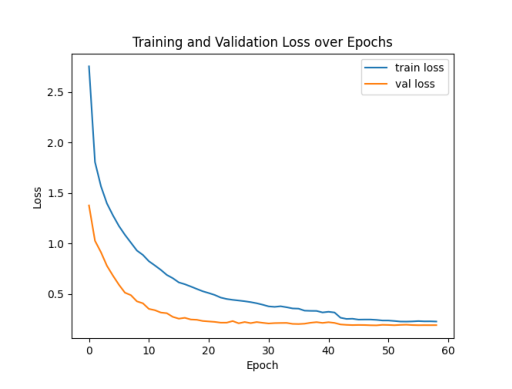

In [56]:
# alternatively, display the image inline (if in a notebook or interactive environment)
plt.imshow(image)
plt.axis('off')
plt.show()